# Использование нейросети для приближённого вычисления функции

#### Подключение библиотек

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
from tqdm import tqdm

#### Генерация данных

In [2]:
N = 20000  # Количество точек
x = torch.empty(N, 1).uniform_(-10, 10)  # x ∈ [-10, 10]
y = torch.empty(N, 1).uniform_(-10, 10)  # y ∈ [-10, 10]

def target_function(x, y):
    return torch.sin(x + 2*y) * torch.exp(-(2*x + y)**2)

z = target_function(x, y)
X = torch.cat([x, y], dim=1)  # Объединяем x и y в единый входной тензор

#### Разделение на train / test / val

In [3]:
X_train, X_temp, y_train, y_temp = train_test_split(X, z, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

#### Создание модели

In [4]:
model = nn.Sequential(
    nn.Linear(2, 128),
    nn.Tanh(),
    nn.Dropout(0.05),
    nn.Linear(128, 128),
    nn.Tanh(),
    nn.Dropout(0.05),
    nn.Linear(128, 128),
    nn.Tanh(),
    nn.Dropout(0.05),
    nn.Linear(128, 128),
    nn.Tanh(),
    nn.Linear(128, 1)
)

#### Функция потерь и оптимизатор

In [5]:
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

#### Обучение модели

In [6]:
num_epochs = 2000
train_losses, val_losses = [], []

for epoch in tqdm(range(num_epochs), desc="Обучение модели"):  # Добавляем tqdm
    y_pred = model(X_train) # прямой проход
    loss = loss_fn(y_pred, y_train)
    optimizer.zero_grad()
    loss.backward() # обратное распространение
    optimizer.step()

    with torch.no_grad():
        val_pred = model(X_val)
        val_loss = loss_fn(val_pred, y_val)

    train_losses.append(loss.item())
    val_losses.append(val_loss.item())

    if epoch % 200 == 0:
        print(f"Эпоха {epoch}, Loss: {loss.item():.5f}, Val Loss: {val_loss.item():.5f}")

Обучение модели:   0%|                                                                | 3/2000 [00:00<03:13, 10.30it/s]

Эпоха 0, Loss: 0.02434, Val Loss: 0.04387


Обучение модели:  10%|██████▎                                                       | 202/2000 [00:20<03:16,  9.16it/s]

Эпоха 200, Loss: 0.01681, Val Loss: 0.01654


Обучение модели:  20%|████████████▍                                                 | 402/2000 [00:40<02:41,  9.92it/s]

Эпоха 400, Loss: 0.01546, Val Loss: 0.01579


Обучение модели:  30%|██████████████████▋                                           | 602/2000 [01:00<02:58,  7.83it/s]

Эпоха 600, Loss: 0.01238, Val Loss: 0.01266


Обучение модели:  40%|████████████████████████▉                                     | 803/2000 [01:21<02:03,  9.70it/s]

Эпоха 800, Loss: 0.00700, Val Loss: 0.00641


Обучение модели:  50%|██████████████████████████████▌                              | 1002/2000 [01:41<01:35, 10.43it/s]

Эпоха 1000, Loss: 0.00370, Val Loss: 0.00377


Обучение модели:  60%|████████████████████████████████████▋                        | 1201/2000 [02:00<01:15, 10.57it/s]

Эпоха 1200, Loss: 0.00269, Val Loss: 0.00257


Обучение модели:  70%|██████████████████████████████████████████▊                  | 1402/2000 [02:19<00:57, 10.46it/s]

Эпоха 1400, Loss: 0.00186, Val Loss: 0.00191


Обучение модели:  80%|████████████████████████████████████████████████▊            | 1602/2000 [02:40<00:37, 10.51it/s]

Эпоха 1600, Loss: 0.00174, Val Loss: 0.00169


Обучение модели:  90%|██████████████████████████████████████████████████████▉      | 1803/2000 [03:01<00:21,  9.18it/s]

Эпоха 1800, Loss: 0.00136, Val Loss: 0.00103


Обучение модели: 100%|█████████████████████████████████████████████████████████████| 2000/2000 [03:22<00:00,  9.86it/s]


#### Оценка модели

In [7]:
with torch.no_grad():
    y_test_pred = model(X_test)
    test_mse = loss_fn(y_test_pred, y_test).item()

print(f"Итоговая MSE на тесте: {test_mse:.5f}")

Итоговая MSE на тесте: 0.00134


#### Сравнение исходной функции и её аппроксимированного варианта при помощи визуализации

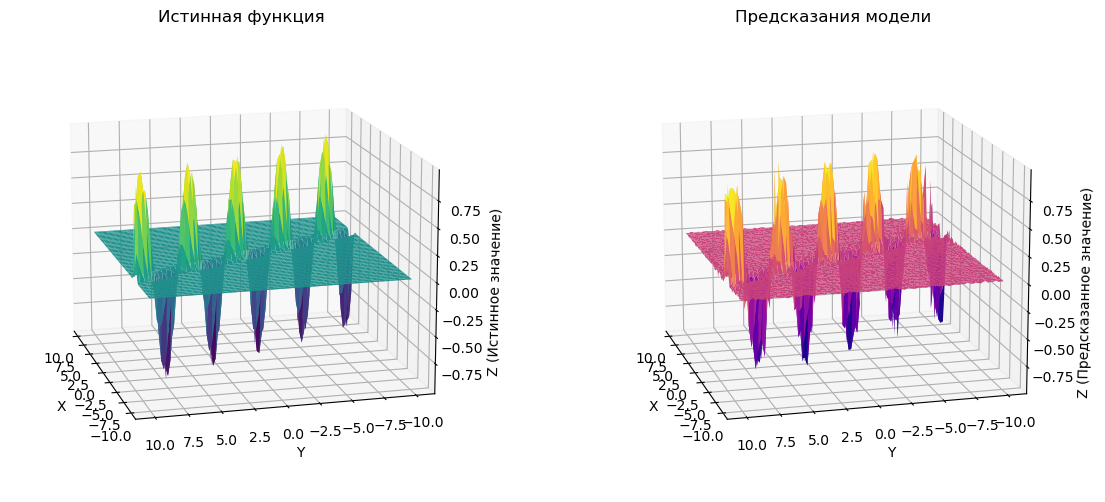

In [8]:
# Генерация сетки значений
x_vals = torch.linspace(-10, 10, 100)
y_vals = torch.linspace(-10, 10, 100)
X_grid, Y_grid = torch.meshgrid(x_vals, y_vals, indexing="xy")

# Истинные значения функции
Z_true = target_function(X_grid, Y_grid).numpy()

# Предсказания модели 
X_flat = torch.cat([X_grid.reshape(-1, 1), Y_grid.reshape(-1, 1)], dim=1)
with torch.no_grad():
    Z_pred = model(X_flat).reshape(100, 100).numpy()

# Создание фигуры с двумя графиками
fig = plt.figure(figsize=(14, 6))

# Первый график - истинная функция
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_surface(X_grid.numpy(), Y_grid.numpy(), Z_true, cmap="viridis")
ax1.set_title("Истинная функция")
ax1.set_xlabel("X")
ax1.set_ylabel("Y")
ax1.set_zlabel("Z (Истинное значение)")
ax1.view_init(elev=15, azim=165)

# Второй график - предсказания модели
ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_surface(X_grid.numpy(), Y_grid.numpy(), Z_pred, cmap="plasma")
ax2.set_title("Предсказания модели")
ax2.set_xlabel("X")
ax2.set_ylabel("Y")
ax2.set_zlabel("Z (Предсказанное значение)")
ax2.view_init(elev=15, azim=165)

# Отображение графиков
plt.show()

## Архитектура нейросети

- **Входной слой:**  
  Модель принимает два входных признака (\(x, y\)), поэтому входной слой состоит из **2 нейронов**. Эти значения поступают в первый скрытый слой через полносвязные (`Linear`) связи.


- **Скрытые слои:**  
  Нейросеть содержит **три скрытых слоя**, каждый из которых состоит из **128 нейронов**. Эти слои позволяют модели находить сложные 
  нелинейные зависимости в данных и улучшать точность предсказаний.


- **Функция активации:**  
  В качестве функции активации после каждого скрытого слоя используется **гиперболический тангенс (`Tanh()`)**.  
  Эта функция хорошо подходит для данной задачи, так как её выходные значения лежат в диапазоне \([-1,1]\), что соответствует выходу целевой функции. (`Tanh()`) лучше (`ReLU()`) в данной задаче, так как он сохраняет отрицательные значения, имеет выход в диапазоне [−1,1], центрирован вокруг 0, что ускоряет обучение.


- **Dropout:**  
  После каждого скрытого слоя применяется **Dropout с вероятностью 5% (`Dropout(0.05)`)**.  
  Эта техника предотвращает переобучение, временно отключая 5% случайных нейронов во время обучения.  
  Таким образом, модель становится более устойчивой к шуму в данных и лучше обобщает знания.


- **Шаг обучения:**  
  Выбранное значение `learning rate = 0.001` обеспечивает баланс между скоростью сходимости и стабильностью обучения.
  
  
- **Выходной слой:**  
  Выходной слой состоит из **1 нейрона**, так как модель выполняет задачу регрессии и должна предсказывать одно числовое значение, соответствующее значению функции \( f(x, y) \).

## Результаты аппроксимации функции нейросетью

- **Итоговая MSE на тесте:** `0.00134`
- **Время обучения:** `3 мин 22 сек`
- **Визуализация:**  графики **очень похожи**, значит нейросеть **успешно аппроксимировала** целевую функцию.